# Machine Learning

### setting up

In [1]:
# loading in packages

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import janitor


In [2]:
# loading in the dataframe

path = r'/Users/johntam/cf_data_analysis/tasks/A4/code/clean_data'
tdhr = pd.read_pickle(os.path.join(path,'tdhr.pkl'))

In [40]:
# taking a look at the data

sample = tdhr.loc[0:100]
pd.set_option('display.max_columns', None)
sample.columns

Index(['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_id', 'add_to_cart_order',
       'reordered', 'product_name', 'aisle_id', 'department_id', 'prices',
       'price_range_loc', 'busiest_days', 'busiest_period_of_day',
       'average_price', 'spender_type', 'max_order', 'loyalty_flag',
       'median_day_since_ordered', 'customer_freq', 'gender', 'state', 'age',
       'date_joined', 'n_dependants', 'fam_status', 'income', 'region',
       'household', 'age_gender', 'income_spender', 'pet_owner', 'vegetarian',
       'new_customer'],
      dtype='object')

In [41]:
sample.head(30)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_days,busiest_period_of_day,average_price,spender_type,max_order,loyalty_flag,median_day_since_ordered,customer_freq,gender,state,age,date_joined,n_dependants,fam_status,income,region,household,age_gender,income_spender,pet_owner,vegetarian,new_customer
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77,7,9.0,mid-range product,regular days,average orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,1.0
1,2398795,1,2,3,7,15.0,196,1,1,Soda,77,7,9.0,mid-range product,slowest days,average orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
2,473747,1,3,3,12,21.0,196,1,1,Soda,77,7,9.0,mid-range product,slowest days,most orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
3,2254736,1,4,4,7,29.0,196,1,1,Soda,77,7,9.0,mid-range product,slowest days,average orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
4,431534,1,5,4,15,28.0,196,1,1,Soda,77,7,9.0,mid-range product,slowest days,most orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
5,3367565,1,6,2,7,19.0,196,1,1,Soda,77,7,9.0,mid-range product,regular days,average orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
6,550135,1,7,1,9,20.0,196,1,1,Soda,77,7,9.0,mid-range product,busiest days,most orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
7,3108588,1,8,1,14,14.0,196,2,1,Soda,77,7,9.0,mid-range product,busiest days,most orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
8,2295261,1,9,1,16,0.0,196,4,1,Soda,77,7,9.0,mid-range product,busiest days,most orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0
9,2550362,1,10,4,8,30.0,196,1,1,Soda,77,7,9.0,mid-range product,slowest days,average orders,6.367797,low spender,10,new customer,20.5,non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,south,4,1,6,0,1,0.0


### focus 08 - machine learning

In [56]:
# setting up

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### redefinng spender_type col

In [57]:
# creating new column that tracks average order cost

tdhr['avg_order_cost'] = (tdhr.groupby(['user_id', 'order_id'])['prices']
                          .transform('sum')
                          .groupby(tdhr['user_id'])
                          .transform('mean'))


In [58]:
# adjusting spender column - differentiating by mean

tdhr.loc[tdhr['avg_order_cost'] < 94, 'spender_type' ] = 0
tdhr.loc[tdhr['avg_order_cost'] >= 94, 'spender_type' ] = 1

#### creating a subset of data

In [59]:
# creating subset of data and one-hot encoding categorical variables

data = (tdhr.loc[:,['spender_type','avg_order_cost','user_id','fam_status','age', 'loyalty_flag','customer_freq', 'gender','n_dependants', 'income',
                    'vegetarian','pet_owner']]
            .drop_duplicates(subset = ['user_id'], keep = 'first')
            .sort_values('user_id')
            .reset_index(drop=True) 
        )

data = (pd.concat([data, pd.get_dummies(data[['fam_status','loyalty_flag','customer_freq','gender']])], axis=1)
    .clean_names()
    .reset_index(drop = True)
)

In [60]:
# changing data type to int

data.spender_type = data.spender_type.astype('int')
data.spender_type.dtype

dtype('int64')

In [61]:
# selecting the columns that we want to keep
cols_to_keep = ['spender_type', 'age','n_dependants', 'income', 'vegetarian',
       'pet_owner', 'fam_status_living_with_parents_and_siblings', 'loyalty_flag_new_customer',
       'customer_freq_regular_customer','gender_female']

data = data[cols_to_keep]

In [23]:
data.columns

Index(['spender_type_high_spender', 'age', 'n_dependants', 'income',
       'vegetarian', 'pet_owner',
       'fam_status_living_with_parents_and_siblings',
       'loyalty_flag_new_customer', 'customer_freq_regular_customer',
       'gender_female'],
      dtype='object')

In [100]:
data.head()

,spender_type_high_spender,age,n_dependants,income,vegetarian,pet_owner,fam_status_living_with_parents_and_siblings,loyalty_flag_new_customer,customer_freq_regular_customer,gender_female
0,0,31,3,40423,1,0,0,1,0,1
1,1,68,3,64940,0,0,0,0,1,1
2,1,33,3,93240,1,0,0,0,0,1
3,0,31,3,45435,1,0,0,1,1,0
4,1,39,2,89095,0,1,0,0,0,0


#### eda

In [74]:
# setting up

sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

/var/folders/6p/dg2x5f3j5clbf9xgg9xqfxjh0000gn/T/ipykernel_4780/2473234104.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(data.corr(), dtype=np.bool)
/var/folders/6p/dg2x5f3j5clbf9xgg9xqfxjh0000gn/T/ipykernel_4780/2473234104.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype=np.bool)
/var/folders/6p/dg2x5f3j5clbf9xgg9xqfxjh0000gn/T/ipykernel_4780/2473234104.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is

<AxesSubplot: >

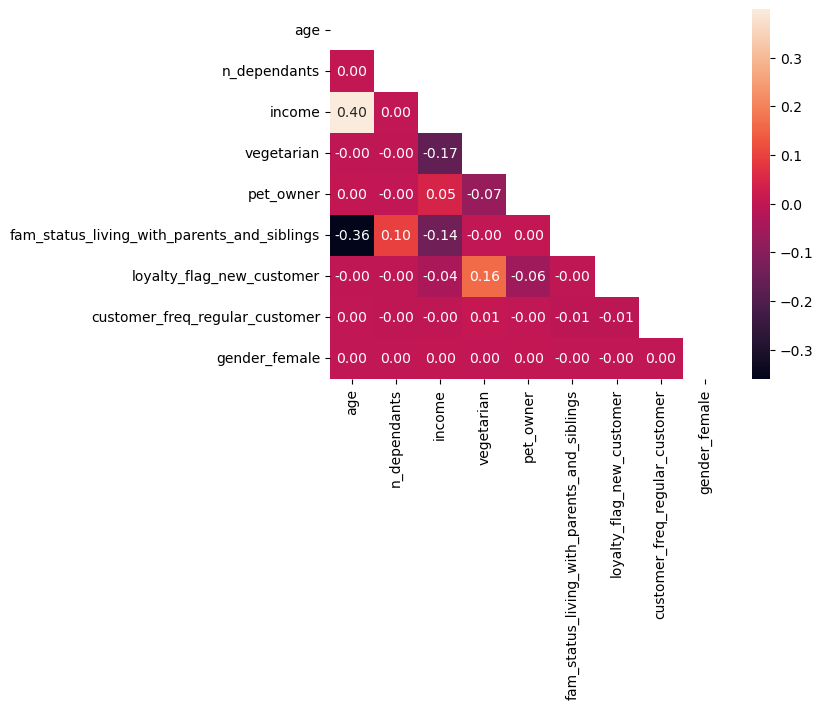

In [18]:
# creating heat map to see correlations
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data.corr(), annot = True, fmt = '.2f', mask = mask)

## we note that there may be a couple of variables that we are concerned about since they have a high correlation 
## with another variable: fam_status_living_with_parents_and_siblings, age, and income

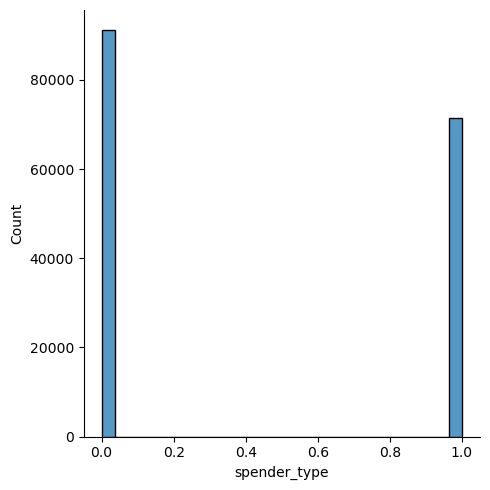

In [15]:
# we notice that there is a slight imbalance in our dependent variable

sns.displot(data.spender_type)

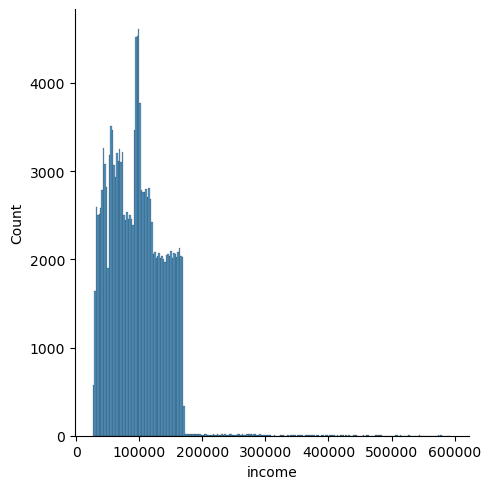

In [55]:
# there are many outliers that we will need to take care of

sns.displot(data['income'])

#### further subsetting & data preparation

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2 , mutual_info_classif
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler

In [63]:
# defining independent and dependent variables

# removing outliers in income col first and then defining dependent variables

z_scores = (data.income - np.mean(data.income)) / np.std(data.income)

data = data[np.abs(z_scores) < 3]

X = data.iloc[:,1:10]

y = data.iloc[:,0] # sepnder type

In [66]:
# using SelectKBest to find the best columns to use 

selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(X, y)
X.columns[selector.get_support()]

# after removing age and income, we find our new variables

Index(['income', 'vegetarian', 'pet_owner', 'loyalty_flag_new_customer',
       'customer_freq_regular_customer'],
      dtype='object')

In [19]:
# Using VIF to avoid multicolinearity

# Calculate VIF for each independent variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print results
print(vif)

# fom the initial results, we will have to remove age and income

                                     variables       VIF
0                                       income  3.228568
1                                 n_dependants  2.450657
2                                   vegetarian  1.587269
3                                    pet_owner  1.087700
4  fam_status_living_with_parents_and_siblings  1.063537
5                    loyalty_flag_new_customer  1.700604
6               customer_freq_regular_customer  1.392607
7                                gender_female  1.831382


In [34]:
X.columns

Index(['age', 'n_dependants', 'income', 'vegetarian', 'pet_owner',
       'fam_status_living_with_parents_and_siblings',
       'loyalty_flag_new_customer', 'customer_freq_regular_customer',
       'gender_female'],
      dtype='object')

In [64]:
# changing X to new selected columns
X = X[['income','n_dependants','vegetarian', 'pet_owner',
       'fam_status_living_with_parents_and_siblings',
       'loyalty_flag_new_customer', 'customer_freq_regular_customer',
       'gender_female']]

In [67]:
# running the VIF check shows that these new variables are fine 
# choosing the best variables

X = X[['income', 'vegetarian', 'pet_owner', 'loyalty_flag_new_customer',
       'customer_freq_regular_customer']]

In [68]:
# scaling the income variable so that the classifier does not become biased by larger numbers
 
X[['income']] = MinMaxScaler(feature_range=(0, 1)).fit_transform(X[['income']])

In [23]:
X.head(20)

,income,vegetarian,loyalty_flag_new_customer,customer_freq_regular_customer,gender_female
0,0.073405,1,1,0,1
1,0.197350,0,0,1,1
2,0.340419,1,0,0,1
3,0.098743,1,1,1,0
4,0.319465,0,0,0,0
5,0.135552,0,1,0,0
6,0.689110,1,1,1,1
7,0.714791,0,1,0,0
8,0.409608,1,0,0,0
9,0.350010,0,0,0,1


#### XGBoost Classifier

In [69]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import BaggingClassifier

In [70]:
# creating train and testing splits

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [71]:
# adjusting for imbalance in dependent variable

# create an instance of the RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the oversampling to the training data
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)


In [72]:
# creating xgboost classifier

xgb_clf = xgb.XGBClassifier(objective='binary:logistic') # setting this objective should aid in our binary classification 

# setting new params found below
xgb_clf.set_params(max_depth = 3, n_estimators = 50, subsample = 0.8, 
                   learning_rate = 0.1, colsample_bytree = 0.8, alpha = 0, reg_lambda = 0)

# training the classifier on the training set
xgb_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

##### adjusting parameters

In [58]:
# adjusting num parallel tree and tree depth in order to find optimal hyper parameters

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(xgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'max_depth': 3, 'n_estimators': 50}


In [59]:
# adjusting learning_rate, subsample, colsample_bytree in order to find optimal hyper parameters

# Define the hyperparameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(xgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'subsample': 0.8}


In [60]:
# adjusting learning_rate, subsample, colsample_bytree in order to find optimal hyper parameters

# Define the hyperparameter grid to search over
param_grid = {
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(xgb_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'alpha': 0, 'lambda': 0}


##### evaluating model

In [74]:
# using the classifier to make predictions on the testing set
y_pred = xgb_clf.predict(X_test)

# evaluating
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.74      0.60      0.66     18087
           1       0.59      0.74      0.66     14286

    accuracy                           0.66     32373
   macro avg       0.67      0.67      0.66     32373
weighted avg       0.68      0.66      0.66     32373



In [76]:
# creating a confusion matrix to evaluate performance 

cm = confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print(df_cm)


          Predicted 0  Predicted 1
Actual 0        10837         7250
Actual 1         3721        10565


In [75]:
# finding importance scores of each variable

importances = xgb_clf.feature_importances_

# Print feature importance scores
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

income: 0.06644044816493988
vegetarian: 0.9008293151855469
pet_owner: 0.024546459317207336
loyalty_flag_new_customer: 0.00311240809969604
customer_freq_regular_customer: 0.0050713904201984406


In [78]:
# finding cross validation scores

cv_scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, cv=5)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)
print('Mean CV score:', np.mean(cv_scores))
print('Standard deviation: %f' % cv_scores.std())

Cross-validation scores: [0.67041199 0.66828162 0.66673539 0.67113356 0.66442169]
Mean CV score: 0.6681968485839207
Standard deviation: 0.002446


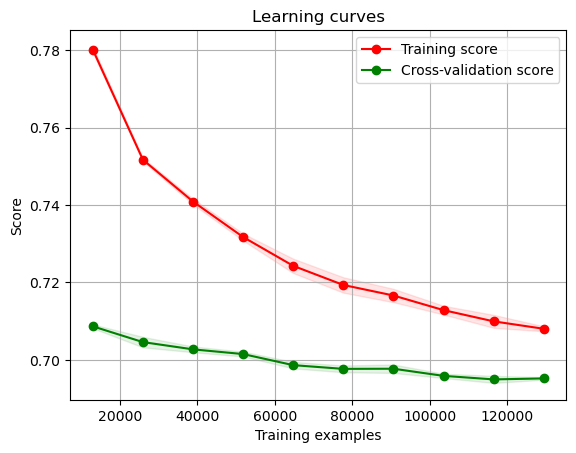

In [130]:
# plotting learning curves

train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curves using cross-validation
train_sizes, train_scores, test_scores = learning_curve(xgb_clf, X, y, cv=5, train_sizes=train_sizes)

# Plot the learning curves
plt.figure()
plt.title('Learning curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1), np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='r')
plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1), np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color='g')
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

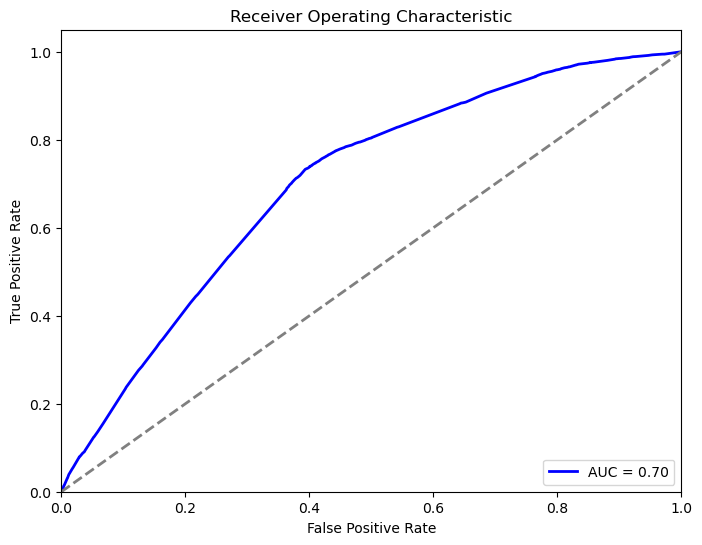

In [77]:
# Obtain predicted probabilities on test set
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

It would seem that the model is not quite up to standards, despite my efforts to make it so. If I were to attempt to improve upon it futher, I would begin with using more methods for variable selection. And afterwords I would move on to using ensemble methods to better the model itself. 

#### Apriori Algorithim - Basket Analysis

much of the code here is from an amazing kaggle post that can be found [here](https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook). The following code expands the code in the kaggle post to cover triplets of items instead of pairs.  

In [20]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import scipy.sparse as sp
from itertools import combinations, groupby
from collections import Counter

In [4]:
basket = tdhr[['order_id','product_name','product_id']]

In [32]:
orders = basket.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2539329    196
2398795    196
473747     196
2254736    196
431534     196
3367565    196
550135     196
3108588    196
2295261    196
2550362    196
Name: item_id, dtype: int64

pandas.core.series.Series

In [27]:
print('dimensions: {0};    unique_orders: {1};   unique_items: {2}'
      .format(orders.shape, len(orders.index.unique()), len(orders.value_counts())))

dimensions: (30992664,);    unique_orders: 3064545;   unique_items: 49644


In [53]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")


# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns generator that yields item triplets, one at a time
def get_item_triplets(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_triplet in combinations(item_list, 3):
            yield item_triplet


# Returns frequency and support associated with item
def merge_item_stats(item_triplets, item_stats):
    return (item_triplets
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqC', 'support': 'supportC'}), left_on='item_C', right_index=True)
                )


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','itemC','freqABC','supportABC','freqA','supportA','freqB','supportB','freqC','supportC','confidenceAtoBC','confidenceBtoAC','confidenceCtoAB','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemC'}), left_on='item_C', right_on='item_id'))


    return rules[columns]

In [54]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))

    # Calculate item frequency and support
    item_stats = freq(order_item).to_frame("freq")
    item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100

    # Filter from order_item items below min support 
    qualifying_items = item_stats[item_stats['support'] >= min_support].index
    order_item = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Filter from order_item orders with less than 3 items
    order_size = freq(order_item.index)
    qualifying_orders = order_size[order_size >= 3].index
    order_item = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 3+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Recalculate item frequency and support
    item_stats = freq(order_item).to_frame("freq")
    item_stats['support'] = item_stats['freq'] / order_count(order_item) * 100

    # Get item triplets generator
    item_triplet_gen = get_item_triplets(order_item)

    # Calculate item triplet frequency and support
    item_triplets = freq(item_triplet_gen).to_frame("freqABC")
    item_triplets['supportABC'] = item_triplets['freqABC'] / len(qualifying_orders) * 100

    print("Item triplets: {:28d}".format(len(item_triplets)))

    # Filter from item_triplets those below min support
    item_triplets = item_triplets[item_triplets['supportABC'] >= min_support]

    print("Item triplets with support >= {}: {:7d}\n".format(min_support, len(item_triplets)))

    # Create table of association rules and compute relevant metrics
    item_triplets = item_triplets.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B', 'level_2': 'item_C'})
    item_triplets = merge_item_stats(item_triplets, item_stats)

    item_triplets['confidenceAtoBC'] = item_triplets['supportABC'] / item_triplets['supportA']
    item_triplets['confidenceBtoAC'] = item_triplets['supportABC'] / item_triplets['supportB']
    item_triplets['confidenceCtoAB'] = item_triplets['supportABC'] / item_triplets['supportC']
    item_triplets['lift'] = item_triplets['supportABC'] / (item_triplets['supportA'] * item_triplets['supportB'] * item_triplets['supportC'])

    # Return association rules sorted by lift in descending order
    return item_triplets.sort_values('lift', ascending=False)


In [55]:
rules = association_rules(orders, 0.003) 

Starting order_item:               30992664
Items with support >= 0.003:           20297
Remaining order_item:              30168373
Remaining orders with 3+ items:     2719924
Remaining order_item:              29644959
Item triplets:                       276379
Item triplets with support >= 0.003:       5



In [52]:
path = r'/Users/johntam/cf_data_analysis/tasks/A4/code/data'

item_name   = pd.read_csv(os.path.join(path, 'products.csv'))
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,itemC,freqABC,supportABC,freqA,supportA,freqB,supportB,freqC,supportC,confidenceAtoBC,confidenceBtoAC,confidenceCtoAB,lift
0,Oh My Yog! Gingered Pear Trilayer Yogurt,Oh My Yog! Organic Wild Quebec Blueberry Cream...,Oh My Yog! Pacific Coast Strawberry Trilayer Y...,113,0.004155,1660,0.061031,2178,0.080076,2744,0.100885,0.068072,0.051882,0.041181,8.426397
1,Oh My Yog! Madagascar Vanilla Trilayer Yogyurt,Oh My Yog! Organic Wild Quebec Blueberry Cream...,Oh My Yog! Pacific Coast Strawberry Trilayer Y...,142,0.005221,2450,0.090076,2178,0.080076,2744,0.100885,0.057959,0.065197,0.051749,7.174536
2,Coconut Chia Bar,Chocolate Peanut Butter,Acai Berry Chia Bar,173,0.006360,4452,0.163681,4460,0.163975,2753,0.101216,0.038859,0.038789,0.062841,2.341334
3,Raspberry Yoghurt,Blueberry Yoghurt,Strawberry Rhubarb Yoghurt,99,0.003640,7982,0.293464,9322,0.342730,9396,0.345451,0.012403,0.010620,0.010536,0.104757
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% All Natural Greek Strained Yogurt wit...,Total 2% Lowfat Greek Strained Yogurt With Blu...,83,0.003052,28735,1.056463,22010,0.809214,19964,0.733991,0.002888,0.003771,0.004157,0.004863
